# Imports

In [23]:
import os
import warnings
import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.keras import layers, models

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from torchvision import models
from torchvision.models import ResNet50_Weights

from PIL import Image, ImageOps, ImageFilter
import pillow_heif

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import shutil
from tqdm import tqdm
from glob import glob
import pickle

import cv2
from facenet_pytorch import MTCNN
import face_recognition
import dlib

import tensorboard
import matplotlib.pylab as plt

# Preparing the data

In [3]:
df = pd.read_csv('sample_submission.csv')
df.drop(columns="image")
train_data = glob('C:/Users/Senne/AI_Frameworks/Project/trainset/trainset/*.jpg')

def list_extensions(folder_path):
    extensions = set()
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            _, extension = os.path.splitext(filename)
            extensions.add(extension.lower())
    return extensions

def convert_to_jpg(file_path, source_folder):
    try:
        _, extension = os.path.splitext(file_path)
        extension = extension.lower()

        if extension == ".heic":
            heif_file = pillow_heif.open_heif(file_path)
            image = Image.frombytes(
                heif_file.mode, heif_file.size, heif_file.data, "raw"
            )
        else:
            image = Image.open(file_path)

        image = image.convert("RGB")

        base_name = os.path.basename(file_path)
        new_file_path = f"{source_folder}{os.path.splitext(base_name)[0]}.jpg"
        os.remove(file_path)
        image.save(new_file_path, "JPEG")
        print(f"Converted {file_path} to {new_file_path}")

        return new_file_path
    except Exception as e:
        print(f"Failed to convert {file_path}: {e}")
        return None

def convert_images_from_df(df, source_folder):
    new_images = []
    for _, row in df.iterrows():
        file_path = row["File Path"]
        converted_path = convert_to_jpg(file_path, source_folder)
        if converted_path:
            new_images.append(converted_path)
    return new_images


def extract_frame_from_mp4(video_path, output_folder, frame_number=0):
    try:
        video = cv2.VideoCapture(video_path)
        
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success, frame = video.read()
        video.release()

        if not success:
            print(f"Failed to extract frame from {video_path}")
            return None

        base_name = os.path.basename(video_path)
        output_file = os.path.join(output_folder, f"{os.path.splitext(base_name)[0]}.jpg")
        
        os.remove(video_path)
        cv2.imwrite(output_file, frame)
        print(f"Extracted frame from {video_path} and saved to {output_file}")
        return output_file
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        return None

def process_mp4_to_jpg(mp4_df, output_folder):
    jpg_files = []
    for _, row in mp4_df.iterrows():
        video_path = row["File Path"]
        jpg_path = extract_frame_from_mp4(video_path, output_folder)
        if jpg_path:
            jpg_files.append(jpg_path)
    return jpg_files

def list_non_jpg_images(folder_path, image_extensions):
    non_jpg_files = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            _, extension = os.path.splitext(filename)
            if extension.lower() in image_extensions:
                non_jpg_files.append(file_path)
    return non_jpg_files

source_folder = "C:/Users/Senne/AI_Frameworks/Project/Trainset/Trainset"
output_folder = "C:/Users/Senne/AI_Frameworks/Project/Trainset/Trainset/"

extensions_in_folder = list_extensions(source_folder)

extensions_in_folder.discard(".jpg")
if ".mp4" in extensions_in_folder:
    mp4_Extension = ".mp4"

print("Extensions found in the folder:")
for ext in sorted(extensions_in_folder):
    print(ext if ext else "No extension (e.g., hidden or extensionless files)")

non_jpg_images = list_non_jpg_images(source_folder, extensions_in_folder)
img_not_jpg_df = pd.DataFrame(non_jpg_images, columns=["File Path"])

if ".mp4" in extensions_in_folder:
    mp4_images = list_non_jpg_images(source_folder, mp4_Extension)
    if mp4_images:
        mp4_img_df = pd.DataFrame(mp4_images, columns=["File Path"])
    
convert_images_from_df(img_not_jpg_df, output_folder)
if ".mp4" in extensions_in_folder:
    jpg_files = process_mp4_to_jpg(mp4_img_df, output_folder)
    mp4_to_jpg_df = pd.DataFrame(jpg_files, columns=["image"])

Extensions found in the folder:


In [4]:
if (len(train_data) != len(df)):

    fileNames = []
        
    for i in range(len(train_data)):
        img_path = train_data[i]
        File_name = os.path.splitext(os.path.basename(img_path))[0]
        File_name = File_name.lstrip('0')
        File_name = int(File_name)
        fileNames.append(File_name)

    full_range = set(range(1, 832))  
    present_values = set(fileNames)  
    missing_values = sorted(full_range - present_values)  

    df = df[~df['image'].isin(missing_values)]

    df.reset_index(drop=True, inplace=True)
        

train_data_series = pd.Series(train_data, index=df.index, name="image_path")
Update_labels = pd.concat([df, train_data_series], axis=1)

correct = 0
false = 0

for i in range(len(Update_labels)):
    img_idx = Update_labels["image"][i]
    img_path = Update_labels["image_path"][i]
    File_name = os.path.splitext(os.path.basename(img_path))[0]
    File_name = File_name.lstrip('0')
    File_name = int(File_name)
        
    if img_idx == File_name:
        correct += 1
    else:
        false +=1

#print(correct)
#print(false)

Update_labels = Update_labels.dropna(subset=['label_name'])
Update_labels = Update_labels[(Update_labels['label_name'] != '22') & (Update_labels['label_name'].str.strip().str.lower() != 'nothing')]
Correct_Labels = ['Akif', 'Alper', 'Bart', 'Daiane', 'Florian', 'Konrad', 'Lasse', 'Matthias', 'Michiel', 'Nelli', 'Raul', 'Senne', 'Seppe', 'Youssef',]


incorrect_labels_info  = []
for idx, label in Update_labels['label_name'].dropna().items():
    labels = label.split(';')
    for lbl in labels:
        lbl = lbl.strip().capitalize()
        if lbl not in Correct_Labels:
            incorrect_labels_info.append((idx, lbl))
            break
incorrect_labels_df = pd.DataFrame(incorrect_labels_info, columns=['Index', 'Incorrect Label'])


corrections = {
    'Alif' : 'Akif',
    'Asper' : 'Alper',
    'Nille' : 'Nelli',
    'Floarian' : 'Florian',
    'Lesse' : 'Lasse',
    'Alpre' : 'Alper',
    'Mattias' : 'Matthias'
}

def process_labels(label):
    labels = label.split(';')
    corrected_labels = []

    for lbl in labels:
        lbl = lbl.strip().capitalize()
        if lbl in corrections:
            corrected_labels.append(corrections[lbl])
        else:
            corrected_labels.append(lbl)

    return '; '.join(corrected_labels)

Update_labels['label_name'] = Update_labels['label_name'].dropna().apply(process_labels)

for i in range(len(incorrect_labels_df)):
    idx = incorrect_labels_df['Index'].iloc[i]
    if idx in Update_labels.index:
        incorrect_labels_df.at[i, 'Corrected Label'] = Update_labels.loc[idx, 'label_name']

all_labels = (
    Update_labels['label_name']
    .dropna()                         
    .astype(str)                      
    .str.split(';')                   
    .explode()                        
    .str.strip()                     
    .str.capitalize()                 
    .unique()                         
)
labels_list = all_labels.tolist()

bad_labels_list = [label for label in labels_list if label not in Correct_Labels]

train_data = Update_labels['image_path']
df = Update_labels[['image', 'label_name']]



In [5]:

trainset_folder = 'C:/Users/Senne/AI_Frameworks/Project/trainset/trainset'
unable_to_use_folder = 'C:/Users/Senne/AI_Frameworks/Project/unable_to_use'

if not os.path.exists(unable_to_use_folder):
    os.makedirs(unable_to_use_folder)

train_data_image_paths = train_data.dropna().unique()

all_image_files_in_trainset = [f for f in os.listdir(trainset_folder) if f.endswith('.jpg')]

files_to_move = [file for file in all_image_files_in_trainset if os.path.join(trainset_folder, file) not in train_data_image_paths]

for file in files_to_move:
    src_path = os.path.join(trainset_folder, file)
    dest_path = os.path.join(unable_to_use_folder, file)
    try:
        shutil.move(src_path, dest_path)
        print(f"Moved {file} to unable_to_use folder.")
    except Exception as e:
        print(f"Error moving {file}: {e}")


In [6]:
index = 435
img_cv2 = cv2.imread(train_data[index])
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
img_cv2.shape

(1728, 2304, 3)

# Checking Images

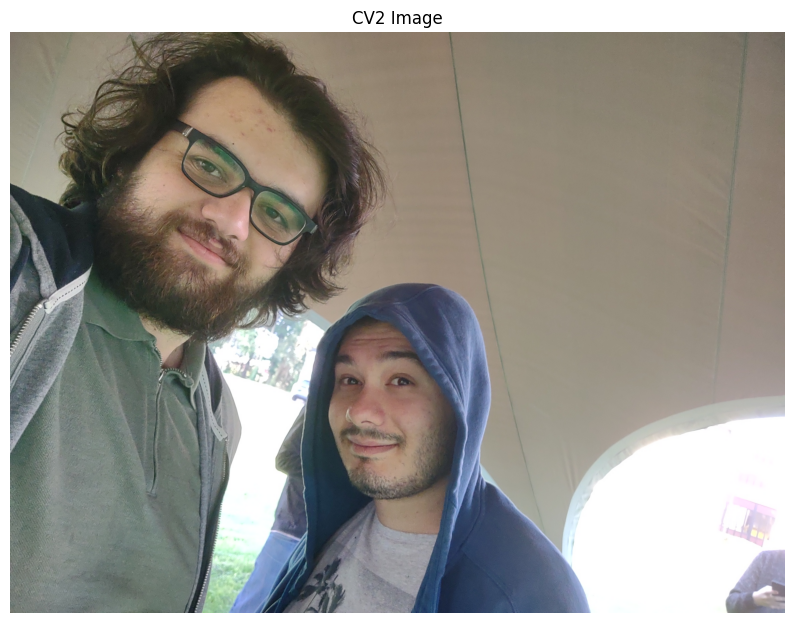

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(img_cv2)
ax.set_title('CV2 Image')
plt.show()

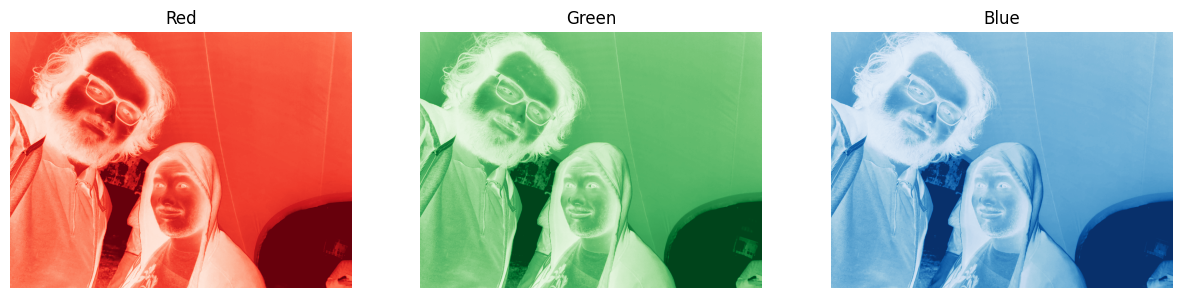

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].imshow(img_cv2[:,:,0], cmap='Reds')
axs[1].imshow(img_cv2[:,:,1], cmap='Greens')
axs[2].imshow(img_cv2[:,:,2], cmap='Blues')
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].set_title('Red')
axs[1].set_title('Green')
axs[2].set_title('Blue')
plt.show()

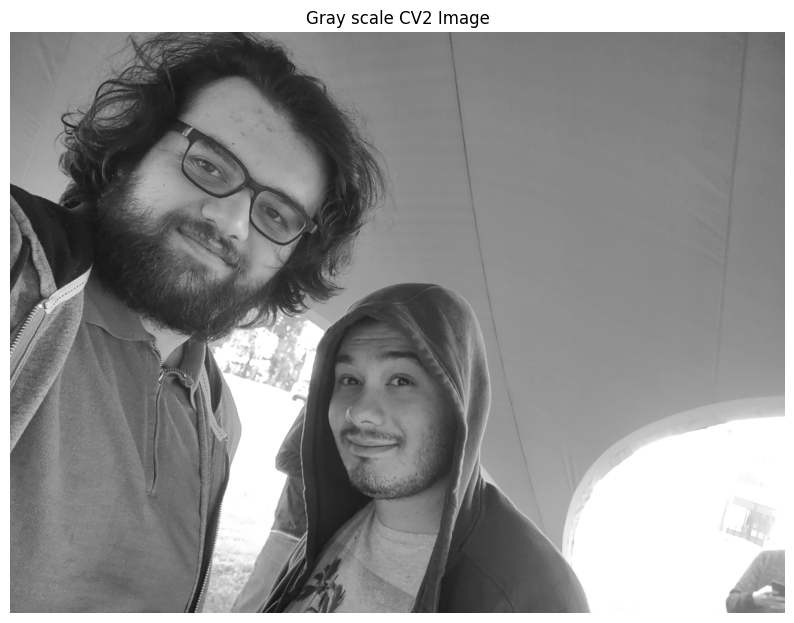

In [9]:
gray_img = cv2.cvtColor(img_cv2, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.imshow(gray_img, cmap='gray')
ax.set_title('Gray scale CV2 Image')
plt.show()

# Detecting Faces

In [10]:
"""
frontal_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
profile_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

def detect_and_draw_faces_combined(img):
    # Check if the input image is grayscale or not
    print("Image shape:", img.shape)
    
    # Convert to grayscale if the image is in RGB
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        print("Image is converted into grayscale")
    else:
        gray = img
        print("Is the image already grayscale? It should have only 1 channel:")

    # Detect frontal faces
    frontal_faces = frontal_face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Detect profile faces (both orientations - left and right)
    profile_faces = profile_face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Flip image horizontally to detect faces on the opposite side (right profile)
    flipped_gray = cv2.flip(gray, 1)
    flipped_profile_faces = profile_face_cascade.detectMultiScale(flipped_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Adjust the coordinates for flipped profile faces
    for (x, y, w, h) in flipped_profile_faces:
        profile_faces = list(profile_faces)  # Convert to list for appending
        profile_faces.append((gray.shape[1] - x - w, y, w, h))  # Mirror the x-coordinate
        profile_faces = tuple(profile_faces)  # Convert back to tuple

    # Combine frontal faces and profile faces (both orientations)
    all_faces = list(frontal_faces) + list(profile_faces)

    # Remove duplicates (if any) by comparing tuples of (x, y, w, h) coordinates
    unique_faces = []
    for face in all_faces:
        face_tuple = tuple(face)  # Convert to tuple of coordinates
        if face_tuple not in unique_faces:
            unique_faces.append(face_tuple)

    # Print the number of faces detected for debugging
    print(f"Number of faces detected: {len(unique_faces)}")

    # Draw rectangles around detected faces on the image
    if len(unique_faces) > 0:
        for (x, y, w, h) in unique_faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
    else:
        print("No faces detected.")

    # Display the image with rectangles drawn (if faces are detected)
    if len(img.shape) == 3:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

detect_and_draw_faces_combined(img_cv2)
"""

'\nfrontal_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + \'haarcascade_frontalface_alt.xml\')\nprofile_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + \'haarcascade_profileface.xml\')\n\ndef detect_and_draw_faces_combined(img):\n    # Check if the input image is grayscale or not\n    print("Image shape:", img.shape)\n    \n    # Convert to grayscale if the image is in RGB\n    if len(img.shape) == 3:\n        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n        print("Image is converted into grayscale")\n    else:\n        gray = img\n        print("Is the image already grayscale? It should have only 1 channel:")\n\n    # Detect frontal faces\n    frontal_faces = frontal_face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))\n\n    # Detect profile faces (both orientations - left and right)\n    profile_faces = profile_face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))\n\n    # Flip image h

In [11]:
"""
# Check if CUDA is available
cuda_device = dlib.cuda.get_num_devices()
if cuda_device > 0:
    print("CUDA is available. Using GPU for face detection.")
    # Load CNN-based face detector with CUDA
    detector = dlib.cnn_face_detection_model_v1('C:/Users/Senne/AI_Frameworks/Project/Models/mmod_human_face_detector.dat')
else:
    print("CUDA is not available. Falling back to CPU.")
    # Fallback to CPU detector if CUDA is not available
    detector = dlib.cnn_face_detection_model_v1('C:/Users/Senne/AI_Frameworks/Project/Models/mmod_human_face_detector.dat')

def detect_faces_Dlib(img):
    img_resized = cv2.resize(img, (640, 480))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        x1, y1, x2, y2 = (face.rect.left(), face.rect.top(), face.rect.right(), face.rect.bottom())
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    print(f"Number of faces detected: {len(faces)}")

    if len(img.shape) == 3:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    
    return len(faces)


#detect_faces_Dlib(img_cv2)
"""

'\n# Check if CUDA is available\ncuda_device = dlib.cuda.get_num_devices()\nif cuda_device > 0:\n    print("CUDA is available. Using GPU for face detection.")\n    # Load CNN-based face detector with CUDA\n    detector = dlib.cnn_face_detection_model_v1(\'C:/Users/Senne/AI_Frameworks/Project/Models/mmod_human_face_detector.dat\')\nelse:\n    print("CUDA is not available. Falling back to CPU.")\n    # Fallback to CPU detector if CUDA is not available\n    detector = dlib.cnn_face_detection_model_v1(\'C:/Users/Senne/AI_Frameworks/Project/Models/mmod_human_face_detector.dat\')\n\ndef detect_faces_Dlib(img):\n    img_resized = cv2.resize(img, (640, 480))\n    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)\n    faces = detector(gray)\n\n    for face in faces:\n        x1, y1, x2, y2 = (face.rect.left(), face.rect.top(), face.rect.right(), face.rect.bottom())\n        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)\n\n    print(f"Number of faces detected: {len(faces)}")\n\n    i

In [12]:
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(keep_all=True, device=device)
print(f"Using device: {device}")

PyTorch version: 2.2.2+cu118
Torchvision version: 0.17.2+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Using device: cuda


detecting face
60 36 145 137
360 216 870 822
face cords found: 360,216,870,822
[[[107  99  80]
  [109 101  82]
  [107  98  81]
  ...
  [ 45  47  34]
  [ 43  45  32]
  [ 42  44  31]]

 [[118 110  91]
  [128 120 101]
  [113 106  88]
  ...
  [ 43  45  32]
  [ 42  44  31]
  [ 41  43  30]]

 [[122 115  96]
  [142 135 116]
  [131 124 105]
  ...
  [ 45  47  34]
  [ 44  46  33]
  [ 43  45  32]]

 ...

 [[ 38  50  40]
  [ 38  50  40]
  [ 38  48  40]
  ...
  [153 153 151]
  [141 140 136]
  [130 129 125]]

 [[ 44  57  47]
  [ 39  52  42]
  [ 38  49  41]
  ...
  [166 168 165]
  [153 154 149]
  [140 139 135]]

 [[ 46  59  49]
  [ 39  52  42]
  [ 39  50  42]
  ...
  [173 175 172]
  [155 156 151]
  [144 145 140]]]


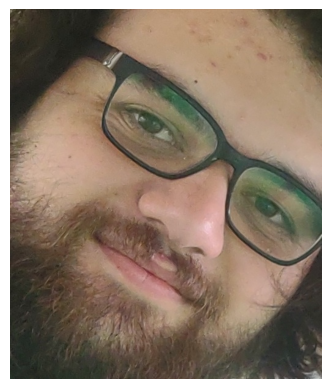

detecting face
157 147 215 225
942 882 1290 1350
face cords found: 942,882,1290,1350
[[[174 190 189]
  [181 197 196]
  [186 201 198]
  ...
  [ 65  72 100]
  [ 70  79 108]
  [ 70  79 108]]

 [[177 193 192]
  [182 196 196]
  [180 195 192]
  ...
  [ 64  71  99]
  [ 72  81 110]
  [ 71  80 109]]

 [[182 196 196]
  [183 197 197]
  [178 192 192]
  ...
  [ 64  71 100]
  [ 73  80 109]
  [ 68  77 106]]

 ...

 [[ 28  49  66]
  [ 30  51  68]
  [ 33  50  66]
  ...
  [ 89  75  74]
  [ 90  75  72]
  [ 90  76  73]]

 [[ 28  49  66]
  [ 30  51  68]
  [ 34  51  67]
  ...
  [ 92  78  75]
  [ 91  77  74]
  [ 92  78  75]]

 [[ 30  51  68]
  [ 30  51  68]
  [ 33  50  66]
  ...
  [ 92  78  75]
  [ 92  78  75]
  [ 93  79  76]]]


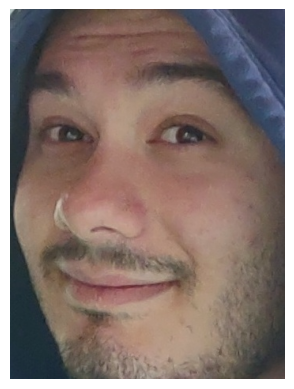

Number of faces detected: 2
In photo: Akif; Alper


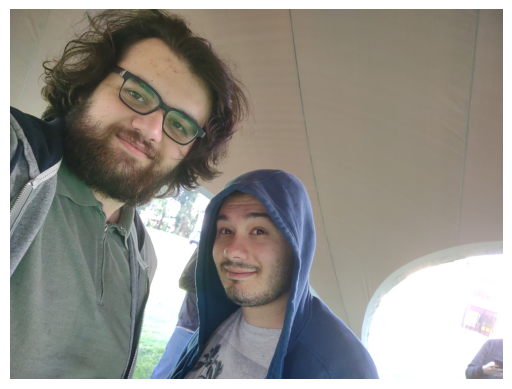

2

In [13]:
Check_FilePath = "C:/Users/Senne/AI_Frameworks/Project/check"

def detect_faces_mtcnn_WithImages(img, position):
    try:
        height, width, _ = img.shape
        resized_img = cv2.resize(img, (width // 6, height // 6))
        boxes, _ = mtcnn.detect(resized_img)

        if boxes is None:
            return 0

        boxes = sorted(boxes, key=lambda box: box[0])

        for box in boxes:
            print("detecting face")

            x1, y1, x2, y2 = [int(coord) for coord in box]
            print(x1, y1, x2, y2)

            x1, y1, x2, y2 = x1 * 6, y1 * 6, x2 * 6, y2 * 6
            height, width, _ = img.shape
            print(x1, y1, x2, y2)

            x1 = max(0, min(x1, width - 1))
            y1 = max(0, min(y1, height - 1))
            x2 = max(0, min(x2, width - 1))
            y2 = max(0, min(y2, height - 1))

            print(f"face cords found: {x1},{y1},{x2},{y2}")
            cropped_face = img[y1:y2, x1:x2]
            #cv2.rectangle(Resize_save_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            print(cropped_face)

            Test = os.path.join(Check_FilePath, f"test.jpg")
            cv2.imwrite(Test, cropped_face)

            tmp_img = cv2.imread(Test)

            if len(tmp_img.shape) == 3:
                plt.imshow(tmp_img)
                plt.axis('off')
                plt.show()
            else:
                plt.imshow(tmp_img, cmap='gray')
                plt.axis('off')
                plt.show()
            

        print(f"Number of faces detected: {len(boxes)}")
        print(f"In photo: {df["label_name"][position]}")

        if len(img.shape) == 3:
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        else:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

        return len(boxes)
    except Exception as e:
        print(f"Error detecting faces in image index {position}: {e}")
        return 0
    
detect_faces_mtcnn_WithImages(img_cv2, index)

In [14]:
def detect_faces_mtcnn(img, img_index, cropped_faces, default):
    try:
        i = 0
        names = [name.strip() for name in df["label_name"][img_index].split(';')]
        height, width, _ = img.shape
        resized_img = cv2.resize(img, (width // 6, height // 6))
        boxes, _ = mtcnn.detect(resized_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        if boxes is None:
            return 0

        boxes = sorted(boxes, key=lambda box: box[0])

        for box in boxes:
            x1, y1, x2, y2 = [int(coord) for coord in box]

            x1, y1, x2, y2 = x1 * 6, y1 * 6, x2 * 6, y2 * 6
            height, width, _ = img.shape

            x1 = max(0, min(x1, width - 1))
            y1 = max(0, min(y1, height - 1))
            x2 = max(0, min(x2, width - 1))
            y2 = max(0, min(y2, height - 1))

            cropped_face = img[y1:y2, x1:x2]
            cropped_faces.append(cropped_face)

        if default:
            default_folder = "C:/Users/Senne/AI_Frameworks/Project/Cropped/default"
            os.makedirs(default_folder, exist_ok=True)
        else:
            person_folder = os.path.join("C:/Users/Senne/AI_Frameworks/Project/Cropped", names[i])
            os.makedirs(person_folder, exist_ok=True)
                
        i += 1
        #cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        #print(f"Number of faces detected: {len(boxes)}")
        #print(f"In photo: {df["label_name"][img_index]}")
        
        """
        if len(img.shape) == 3:
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        else:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()
        """

        return len(boxes)
    except Exception as e:
        print(f"Error detecting faces in image index {img_index}: {e}")
        return 0

In [15]:
'''
def redetect(img):
    try:
        boxes, _ = mtcnn.detect(img)

        if boxes is None:
            return False

        for box in boxes:
            x1, y1, x2, y2 = [int(coord) for coord in box]
            #cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        return True
    except Exception as e:
        #print(f"Error detecting faces in image: {e}")
        return False
'''

'\ndef redetect(img):\n    try:\n        boxes, _ = mtcnn.detect(img)\n\n        if boxes is None:\n            return False\n\n        for box in boxes:\n            x1, y1, x2, y2 = [int(coord) for coord in box]\n            #cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)\n\n        return True\n    except Exception as e:\n        #print(f"Error detecting faces in image: {e}")\n        return False\n'

In [ ]:
start = 435
length = 1 #len(train_data)

for i in range(length):
    cropped_faces = []
    position = i + start
    img = cv2.imread(train_data[position])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [17]:
start = 0
length = len(train_data)
correct_detection = 0
Bad_detection = 0
default = True
df_cd = []
df_bd = []

validation = pd.DataFrame(columns=['img', 'person'])

Cropped_FilePath = "C:/Users/Senne/AI_Frameworks/Project/Cropped"
Check_FilePath = "C:/Users/Senne/AI_Frameworks/Project/check"

for i in range(length):
    cropped_faces = []
    position = i + start
    img = cv2.imread(train_data[position])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected = detect_faces_mtcnn(img, position, cropped_faces, default)

    img_name = os.path.basename(train_data[position])
    img_name = os.path.splitext(img_name)[0]
    Label_names = [name.strip() for name in df["label_name"][position].split(';')]
    people = len(df["label_name"][position].split(';'))

    if (detected == people):
        correct_detection += 1
        df_cd.append(train_data[position])
        for d in range(people):

            if default == True:
                Img_FilePath = os.path.join(Cropped_FilePath, "default" ,f"{img_name}_{d}.jpg")
                cv2.imwrite(Img_FilePath, cropped_faces[d])

                new_row = pd.DataFrame({'img': [Img_FilePath], 'person': [Label_names[d]]})
                validation = pd.concat([validation, new_row], ignore_index=True)

            if default == False:
                Img_FilePath = os.path.join(Cropped_FilePath, Label_names[d], f"{img_name}_{d}.jpg")
                cv2.imwrite(Img_FilePath, cropped_faces[d])
    else:
        Bad_detection += 1
        df_bd.append(train_data[position])

    print(f"Processed {i+1}/{length} images")

print(f"{correct_detection}/{len(train_data)} was correctly detected(All faces were detected)")
print(f"{Bad_detection}/{len(train_data)} was incorrecly detected(Not all faces were detected)")

Processed 1/712 images
Processed 2/712 images
Processed 3/712 images
Processed 4/712 images
Processed 5/712 images
Processed 6/712 images
Processed 7/712 images
Processed 8/712 images
Processed 9/712 images
Processed 10/712 images
Processed 11/712 images
Processed 12/712 images
Processed 13/712 images
Processed 14/712 images
Processed 15/712 images
Processed 16/712 images
Processed 17/712 images
Processed 18/712 images
Processed 19/712 images
Processed 20/712 images
Processed 21/712 images
Processed 22/712 images
Processed 23/712 images
Processed 24/712 images
Processed 25/712 images
Processed 26/712 images
Processed 27/712 images
Processed 28/712 images
Processed 29/712 images
Processed 30/712 images
Processed 31/712 images
Processed 32/712 images
Processed 33/712 images
Processed 34/712 images
Processed 35/712 images
Processed 36/712 images
Processed 37/712 images
Processed 38/712 images
Processed 39/712 images
Processed 40/712 images
Processed 41/712 images
Processed 42/712 images
P

In [63]:
def zoom_image(image, zoom_factor=1.2):
    width, height = image.size
    new_width = int(width * zoom_factor)
    new_height = int(height * zoom_factor)
    zoomed_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    return zoomed_image.crop((0, 0, width, height))  # Crops back to the original size

def add_noise(image):
    image_array = np.array(image)
    row, col = image_array.shape
    gauss = np.random.normal(0, 25, (row, col))
    noisy_image = np.array(np.clip(image_array + gauss, 0, 255), dtype=np.uint8)
    return Image.fromarray(noisy_image)

def shear_image(image, shear_factor=0.2):
    width, height = image.size
    matrix = [1, shear_factor, 0, shear_factor, 1, 0]
    return image.transform((width, height), Image.AFFINE, matrix)

def random_crop(image, crop_size=(400, 400)):
    width, height = image.size
    crop_width, crop_height = crop_size
    x_offset = random.randint(0, width - crop_width)
    y_offset = random.randint(0, height - crop_height)
    return image.crop((x_offset, y_offset, x_offset + crop_width, y_offset + crop_height))

def perspective_transform(image):
    image_array = np.array(image)
    rows, cols = image_array.shape
    pts1 = np.float32([[50,50], [200,50], [50,200], [200,200]])
    pts2 = np.float32([[10,100], [200,50], [100,250], [210,250]])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(image_array, M, (cols, rows))

def random_blur(image):
    return image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.1, 2.0)))

def augment_image(image):
    augmented_images = []

    augmented_images.append(image)

    flipped_h = ImageOps.mirror(image)
    augmented_images.append(flipped_h)

    flipped_v = ImageOps.flip(image)
    augmented_images.append(flipped_v)

    rotated_random = image.rotate(random.randint(-30, 30), expand=True)
    augmented_images.append(rotated_random)

    zoomed_image = zoom_image(image)
    augmented_images.append(zoomed_image)

    noisy_image = add_noise(image)
    augmented_images.append(noisy_image)

    sheared_image = shear_image(image)
    augmented_images.append(sheared_image)

    cropped_image = random_crop(image)
    augmented_images.append(cropped_image)

    blurred_image = random_blur(image)
    augmented_images.append(blurred_image)

    return augmented_images



In [75]:

DIR = "C:/Users/Senne/AI_Frameworks/Project/Cropped"
save_dir = "C:/Users/Senne/AI_Frameworks/Project/Padding"

model_path = "C:/Users/Senne/AI_Frameworks/Project/Models/Trainer_LBHF.yml"

recognizer = cv2.face.LBPHFaceRecognizer_create()
#recognizer = cv2.face.EigenFaceRecognizer_create()
#recognizer = cv2.face.FisherFaceRecognizer_create()

current_id = 0
label_ids = {}
Names = []
y_labels = []
x_train = []

desired_width = 500
desired_height = 550

for person_folder in os.listdir(DIR):
    person_path = os.path.join(DIR, person_folder)
    if os.path.isdir(person_path) and person_folder != 'default':
        for image_file in os.listdir(person_path):
            img_path = os.path.join(person_path, image_file)
            img_label = os.path.basename(person_path)

            if not img_label in label_ids:
                label_ids[img_label] = current_id
                current_id += 1
            id_ = label_ids[img_label]

            pill_img = Image.open(img_path).convert("L")

            width, height = pill_img.size
            if width >= desired_width and height >= desired_height:
                img_re = pill_img.resize((desired_width, desired_height), Image.Resampling.LANCZOS)
            else:
                top = (desired_height - height) // 2
                bottom = desired_height - height - top
                left = (desired_width - width) // 2
                right = desired_width - width - left

                img_re = Image.new('L', (desired_width, desired_height), (0))
                img_re.paste(pill_img, (left, top)) 

                img_re = img_re.resize((desired_width, desired_height), Image.Resampling.LANCZOS)
                
            img_re.save(os.path.join(save_dir, f"original_{person_folder}_{image_file}"))
            """
            img_array = np.array(img_re, "uint8")
            x_train.append(img_array)
            y_labels.append(id_)

            """
            augmented_images = augment_image(img_re)
            
            for aug_img in augmented_images:
                img_array = np.array(aug_img, "uint8")
                x_train.append(img_array)
                y_labels.append(id_)
                
with open("Labels_faces.pickle", 'wb') as f:
    pickle.dump(label_ids, f)

recognizer.train(x_train, np.array(y_labels))
recognizer.save(model_path)
if os.path.exists(model_path):
    print(f"Model successfully saved to {model_path}")
else:
    print(f"Failed to save the model to {model_path}")

Model successfully saved to C:/Users/Senne/AI_Frameworks/Project/Models/Trainer_LBHF.yml


In [65]:
dir = "C:/Users/Senne/AI_Frameworks/Project/Cropped/default"

P_name = {"personName": 1}
P_name = {n:i for i,n in label_ids.items()}

i = 0
correct = 0
wrong = 0
total = 0

results = pd.DataFrame()

for image_file in os.listdir(dir):
    total += 1
    img_path = os.path.join(dir, image_file)

    true_label = validation['person'][i]

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img.shape

    id_, conf = recognizer.predict(img)

    if conf >= 45 or conf <= 85:

        #print(id_)
        #print(P_name[id_])

        if P_name[id_] == validation['person'][i]:
            #print("Correct!!!")
            correct += 1
        else:
            wrong +=1

    predicted_label = P_name.get(id_, "Unknown")
    
    results = pd.concat([results, pd.DataFrame({
        'image': [img_path],
        'label': [true_label],
        'guess': [predicted_label]
    })], ignore_index=True)

    i += 1

    """++
    if len(img.shape) == 3:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    """
    
    if total % 100 == 0:
        print(f"Processed {total} images")

print(f"{correct}/{total} were correctly predicted")
print(f"{wrong}/{total} were incorrtly predicted")

KeyboardInterrupt: 